In [32]:
import pandas as pd
import numpy as np
from datetime import datetime
import string
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
import pprint


In [33]:
#load data
gross = pd.read_csv("part2cleanedGrosses.csv", index_col=0, encoding='latin-1')
social = pd.read_csv("part2cleanedSocialMedia.csv", index_col=0, encoding='latin-1')
#pre processing 
social['Date'] = pd.to_datetime(social['Date']).dt.strftime('%Y-%m-%d')
gross['week_ending'] = pd.to_datetime(gross['week_ending']).dt.strftime('%Y-%m-%d')
gross['label'] = [1 if x >= 0 else 0 for x in gross['diff_in_dollars']]
social['Show'] = [re.sub(r'\s+', ' ', x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).lower().strip()) for x in social['Show']]
#ain't too proud has weird special characters
gross['show'] = [x.split('¡')[0] for x in gross['show']]
#beautiful carol king has different names 
gross['show'] = [re.sub(r'\s+', ' ', x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).lower().strip()) for x in gross['show']]
gross.loc[gross['show']=='beautiful the carole king musical', 'show']  = 'beautiful'


In [48]:
# Classification Task 1: Grosses - Increase vs. Decrease
# The sale growth of each show for the week is correlated with its social media reactions in previous weeks, 
# predict if growth increased or not in this week. 
# Naive bayes, RF, Decision trees 
social

,Show,Date,FB Likes,Likes Vs.Last Week,cleaned_FB Talking About,Talking Vs.Last Week,cleaned_FB Checkins,Checkins vs.Last Week,Twitter Followers,Twitter vs.Last Week,Instagram Followers,IG Followers vs.Last Week,Current,Type,FB Talking About,FB Checkins,Month,Day,Year,outlier_detection
0,a christmas carol,2019-09-29,244.0,22.0,299.0,-84.0,0.0,0.0,60.0,2.0,257.0,25.0,Upcoming,Play,299,0.0,9,29,2019.0,0.0
1,a christmas carol,2019-09-22,222.0,0.0,383.0,0.0,0.0,0.0,58.0,0.0,232.0,0.0,Upcoming,Play,383,0.0,9,22,2019.0,0.0
2,ain t too proud,2019-09-29,8451.0,152.0,4848.0,-178.0,18743.0,694.0,2971.0,38.0,13279.0,114.0,Current,Musical,4848,18743.0,9,29,2019.0,1.0
3,ain t too proud,2019-09-22,8299.0,150.0,5026.0,1483.0,18049.0,646.0,2933.0,26.0,13165.0,95.0,Current,Musical,5026,18049.0,9,22,2019.0,1.0
4,ain t too proud,2019-09-15,8149.0,113.0,3543.0,-668.0,17403.0,747.0,2907.0,23.0,13070.0,170.0,Current,Musical,3543,17403.0,9,15,2019.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,wicked,2017-07-24,1248323.0,350.0,10650.0,3495.0,207156.0,725.0,125820.0,312.0,158669.0,1882.0,Current,Musical,10650,207156.0,7,24,2017.0,1.0
2117,wicked,2017-07-17,1247973.0,651.0,7155.0,-8589.0,206431.0,1070.0,125508.0,306.0,156787.0,2357.0,Current,Musical,7155,206431.0,7,17,2017.0,1.0
2118,wicked,2017-07-09,1247322.0,386.0,15744.0,4326.0,205361.0,1047.0,125202.0,280.0,154430.0,1269.0,Current,Musical,15744,205361.0,7,9,2017.0,1.0
2119,wicked,2017-07-02,1246936.0,402.0,11418.0,650.0,204314.0,930.0,124922.0,269.0,153161.0,1080.0,Current,Musical,11418,204314.0,7,2,2017.0,1.0


In [49]:
gross_date = [x for x in gross['week_ending'].unique() if x[0:4] in ['2019', '2018', '2017']]
temp_date = [x.date().strftime('%Y-%m-%d') for x in list(pd.to_datetime(gross_date) + pd.Timedelta(1, unit='d'))]
#temp_date2 = [x.date().strftime('%Y-%m-%d') for x in list(pd.to_datetime(gross_date) - pd.Timedelta(1, unit='d'))]
gross_date = gross_date + temp_date #+ temp_date2

names = list(social.columns)
names.append('label')
df = pd.DataFrame(columns = names)

for i in social['Date'].unique():
    temp = (pd.to_datetime(i)-pd.Timedelta(7, unit='d')).date().strftime('%Y-%m-%d')
    if temp in gross_date:
        temp_df = social.loc[social['Date'] == temp,:]
        temp_df['label'] = np.nan
        c = gross.loc[(gross['week_ending'] == temp), ['week_ending', 'show', 'label']]
        for j in temp_df.Show:
            for k in c.show:
                if j in k:
                    temp_df.loc[(temp_df['Show'] == j),'label'] = c.loc[c['show'] == k, 'label'].values
                elif k in j:
                    temp_df.loc[(temp_df['Show'] == j),'label'] = c.loc[c['show'] == k, 'label'].values         
    df = df.append(temp_df,ignore_index = True)
    

In [51]:
df_notnull = df.dropna()
X = df_notnull.loc[:, :'Type'].reset_index(drop=True)
#X = df_notnull.loc[:, ['Show', 'Date','FB Likes','cleaned_FB Talking About','cleaned_FB Checkins','Twitter Followers', 'Instagram Followers','Current','Type','FB Talking About','FB Checkins']].reset_index(drop=True)
y = df_notnull.loc[:, 'label'].reset_index(drop=True).values
#convert categorical data to numerical 
for i in X.columns:
    if type(X[i][0]) == str:
        X[i] = X[i].astype("category").cat.codes
        
normDF = preprocessing.normalize(X, axis=0) 

In [52]:
#decision trees
X_train, X_validate, Y_train, Y_validate = train_test_split(normDF, y, test_size=0.2, random_state=42)

results = []

dt = DecisionTreeClassifier()
kfold = KFold(n_splits= 10, random_state=42, shuffle=False)
cv_results = cross_val_score(dt, X_train, Y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print("Training", msg)
dt.fit(X_train, Y_train)
predictions = dt.predict(X_validate)
result = "%f " % (accuracy_score(Y_validate, predictions))
print("Testing", result)


Training 0.577077 (0.066126)
Testing 0.592105 


In [53]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

kfold = KFold(n_splits= 10, random_state=42, shuffle=False)
cv_results = cross_val_score(knn, X_train, Y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print("Training", msg)
dt.fit(X_train, Y_train)
predictions = dt.predict(X_validate)
result = "%f " % (accuracy_score(Y_validate, predictions))
print("Testing", result)


Training 0.550601 (0.034206)
Testing 0.565789 


In [54]:
#Random Forest Model
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validate = sc.transform(X_validate)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_validate)

print(confusion_matrix(Y_validate,y_pred.round()))
print(classification_report(Y_validate,y_pred.round()))
print(accuracy_score(Y_validate, y_pred.round()))

# figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
# importances = rf.feature_importances_
# feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
# feat_importances.plot(kind='barh')

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, Y_train), 
                                                                         rf.score(X_validate, Y_validate)))


[[46 29]
 [29 48]]
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61        75
         1.0       0.62      0.62      0.62        77

    accuracy                           0.62       152
   macro avg       0.62      0.62      0.62       152
weighted avg       0.62      0.62      0.62       152

0.618421052631579
R^2 Training Score: 0.86 
R^2 Validation Score: 0.05


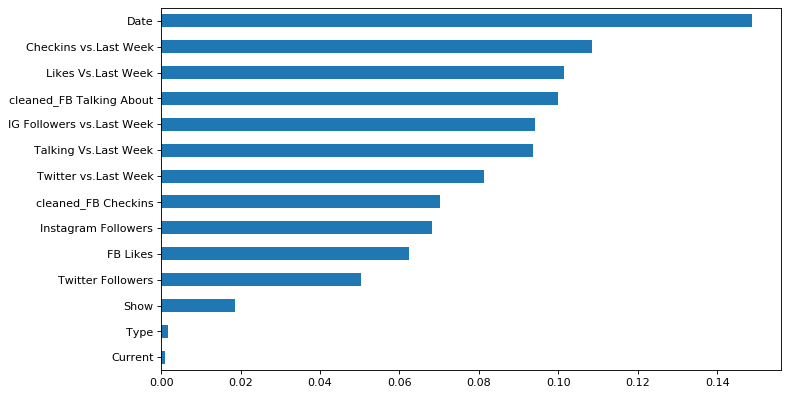

In [55]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

importances = rf.feature_importances_
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')

In [41]:
#association rule
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [44]:
df =pd.read_csv("part2cleanedGrosses.csv", index_col=0, encoding='latin-1')
df['week_ending'] = pd.to_datetime(df['week_ending']).dt.strftime('%Y-%m-%d')
gross_date = [x for x in gross['week_ending'].unique() if int(x[0:4]) > 2000]
all_date = df['week_ending'].unique()

itemset = []
for i in all_date:
    temp = list(gross.loc[(df['week_ending']== i) & df['percent_of_cap'] >= 0.8, 'show'])
    itemset.append(temp)

itemset2 = []
for i in gross_date:
    temp = list(gross.loc[(df['week_ending']== i) & df['percent_of_cap'] >= 0.8, 'show'])
    itemset2.append(temp)


In [46]:
for j in range(0, 2):
    temp = [itemset, itemset2][j]
    te = TransactionEncoder()
    te_ary = te.fit(temp).transform(temp)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    value = [0.4, 0.6, 0.8] #support value

    confidf = pd.DataFrame() 
    supportdf = pd.DataFrame()
    for i in value:
        frequent_itemsets = apriori(df, min_support=i,use_colnames=True)
        confi = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
        frequent_itemsets['support_val'] = i
        confi['support_val'] = i
        supportdf = supportdf.append(frequent_itemsets)
        confidf = confidf.append(confi.iloc[:,[0,1,5,-1]])
        print('#################### Support =', i, '####################')
        pprint.pprint(frequent_itemsets)
        print('####### Calculating the Confidence #######')
        print(confi.iloc[:,[0,1,5,-1]])
    supportdf.to_csv(str('Itemset_support' + str(j) + '.csv'), index=False)
    confidf.to_csv(str('Itemset_confidence'+ str(j) + '.csv'), index=False)


#################### Support = 0.4 ####################
     support                                           itemsets  support_val
0   0.488268                                             (cats)          0.4
1   0.667039                                          (chicago)          0.4
2   0.580447                                (les miså¬å rables)          0.4
3   0.405028                                        (mamma mia)          0.4
4   0.637989                                    (the lion king)          0.4
5   0.923464                         (the phantom of the opera)          0.4
6   0.464246                                           (wicked)          0.4
7   0.412849                   (cats, the phantom of the opera)          0.4
8   0.405028                               (mamma mia, chicago)          0.4
9   0.637989                           (chicago, the lion king)          0.4
10  0.667039                (chicago, the phantom of the opera)          0.4
11  0.464246        

In [56]:
#SVM 
from sklearn import svm
clf = svm.SVC(gamma='scale')

kfold = KFold(n_splits= 10, random_state=42, shuffle=False)
cv_results = cross_val_score(clf, X_train, Y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print("Training", msg)
dt.fit(X_train, Y_train)
predictions = dt.predict(X_validate)
result = "%f " % (accuracy_score(Y_validate, predictions))
print("Testing", result)



Training 0.542213 (0.029230)
Testing 0.585526 
